# **The Necessity for Intervention Fidelity: Unintended Side Effects When Steering LLMs**

*Authors: Jonas B. Raedler, Weiyue Li, Manasvi Goyal, Alyssa Mia Taliotis, Siddharth Swaroop, Weiwei Pan*

---
This is the notebook that accompanies our paper, published at the *Methods and Opportunities at Small Scale (MOSS)* workshop, held at ICML 2025 (Vancouver, Canada).

### **Please Read:**

**Instructions**
1. This notebook makes use of the `transformer_lens` library. The pretrained models that it uses require a lot of memory, so you'll have to change the runtime environment of this notebook: **Change the runtime type from CPU to v2-8 TPU**. This is available in Google Colab free tier (I've tested it successfully --- there might be usage limits after using it for a while, but it should be usable again after a while).

2. Furthermore, Google Colab doesn't seem to have the `transformer_lens` library pre-installed. Try to execute the imports cell - if it fails, **uncomment the `!pip install` command, install the package, and then rerun the imports**.

3. This notebook uses the `google/gemma-2-2b` family of models. Using them requires a huggingface token (which is free). You can get one here: https://huggingface.co/docs/hub/en/security-tokens. Provide your access token in the field `HUGGINGFACE_TOKEN` below.

4. Last but not least, this notebook uses the StereoSet dataset. You can get the data from here: https://github.com/moinnadeem/StereoSet/blob/master/data/dev.json. Download the dev.json file and upload it to this session (on the left under "Files", select "Upload to session storage").


**Further Information**

In the interest of time, this notebook does not run our experiments on the entire dataset (this would take significantly longer than only 3 hours). Instead, we run our experiments on a subset of the data. From the four available bias types, we chose two: "gender" and "race". We also run our experiments on only one dataset (intersentence), use only 30 samples per bias type, and steer at 3 layers (5, 11, 17) instead of every second layer.
These decisions were made to make it possible to run this notebook in 1.5 hours, while still covering the entire experiment spectrum as holistically as possible.

We aimed for a time of 1.5 hours, as one run of this notebook only executes the experiments for either the base or the fine-tuned model. If desired, the reviewer can change the model and rerun the notebook to get the other set of results.

All our decisions can be altered, if desired, though we recommend to keep a wide range of layers (i.e., don't pick 1, 2, 3). We specify these decision in the first cell and they can be altered there.




**1. Import Libraries**
---

In [ ]:
#### MODEL TRAIN STATE
# TRAIN_STATE = "base"    # uncomment depending on which model you want to run
TRAIN_STATE = "instruct"


#### DATASET SPECIFICATION
# mode = "intra"
mode = "inter"    # uncomment depending on which dataset you want to run


#### HYPERPARAMETERS
all_layer_ids = [5, 11, 17]
N_SAMPLES = 30


#### BIAS TYPES
stereo_bias_types = ["gender", "race"]  # ["gender", "profession", "race", "religion"]  -- for time's sake, we will only consider 2 bias types


#### HUGGINGFACE TOKEN
HUGGINGFACE_TOKEN = "your token here"

In [ ]:
# Install if necessary!
#!pip install transformer_lens

In [ ]:
import json
import time
import copy
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
from tqdm import tqdm
from huggingface_hub import login

In [ ]:
login(token=HUGGINGFACE_TOKEN)

**2. Get the StereoSet Data**
---

In [ ]:
DATA_PATH = "dev.json"
with open(DATA_PATH) as dev_file:
    dev = json.load(dev_file)

inter = dev["data"]["intersentence"]
intra = dev["data"]["intrasentence"]

In [ ]:
# get the relevant data from the dev.json stereoset file
def get_metadata(result_dict, row_idx, metadata, mode):

    row_metadata = metadata[row_idx]

    # Basic Information
    result_dict["bias_type"].append(row_metadata["bias_type"])
    result_dict["context"].append(row_metadata["context"])

    result_dict["ans0"].append(row_metadata["sentences"][0]["sentence"])
    result_dict["ans1"].append(row_metadata["sentences"][1]["sentence"])
    result_dict["ans2"].append(row_metadata["sentences"][2]["sentence"])

    result_dict["ans0_answer_type"].append(row_metadata["sentences"][0]["gold_label"])
    result_dict["ans1_answer_type"].append(row_metadata["sentences"][1]["gold_label"])
    result_dict["ans2_answer_type"].append(row_metadata["sentences"][2]["gold_label"])

    return result_dict

In [ ]:
# put the stereoset data into datafrmes
intra_dict = {
    "bias_type": [],
    "context": [],
    "ans0": [],
    "ans1": [],
    "ans2": [],
    "ans0_answer_type": [],
    "ans1_answer_type": [],
    "ans2_answer_type": [],
}

inter_dict = copy.deepcopy(intra_dict)

# Set up df for both intra- and intersentence data
for row_idx in range(len(inter)):
    inter_dict = get_metadata(inter_dict, row_idx, inter, mode="inter")
inter_df = pd.DataFrame.from_dict(inter_dict)

for row_idx in range(len(intra)):
    intra_dict = get_metadata(intra_dict, row_idx, intra, mode="intra")
intra_df = pd.DataFrame.from_dict(intra_dict)

all_dfs = {
    "inter": inter_df,
    "intra": intra_df
}

**3. Prepare Steering Functions**
---

In [ ]:
# this gets the formatted context+question+answer for each entry in the dataset
def get_prompt_and_answer_choices_stereoset(row, data_type):
    choices = ["A. " + row["ans0"], "B. " + row["ans1"], "C. " + row["ans2"]]
    choices_dict = {k: v for k, v in [[choice[0], choice[3:]] for choice in choices]}

    question = "Choose the most appropriate sentence below:"

    context = row["context"]
    prompt = (
        f"{context}\n\n"
        f"{question}\n"
        f"{choices[0]}\n"
        f"{choices[1]}\n"
        f"{choices[2]}\n\n"
        f"Answer: "
    )

    return prompt, choices, choices_dict


# this determines which answer index corresponds to which answer type
def get_answer_ids(row):
    answers = {
        row["ans0_answer_type"]: 0,
        row["ans1_answer_type"]: 1,
        row["ans2_answer_type"]: 2
    }
    stereo_idx = answers["stereotype"]
    anti_stereo_idx = answers["anti-stereotype"]
    unrelated_idx = answers["unrelated"]

    return stereo_idx, anti_stereo_idx, unrelated_idx


# this converts a prediction (index) into answer type
def determine_answer_type_stereoset(row, pred_column):
    model_pred = str(row[pred_column])
    answer_type = row[f"ans{model_pred}_answer_type"]

    answer_type_to_label = {
        "unrelated": 0,
        "stereotype": 1,
        "anti-stereotype": 2
    }

    return answer_type_to_label[answer_type]


# this defines the steering hook that is used for intervention
def make_steering_hook(curr_steering_config):

    def steering_hook(resid_pre, hook):
        if resid_pre.shape[1]==1:
            return

        # Init from config
        COEFF = curr_steering_config["COEFF"]
        steer_vector = curr_steering_config["steering_vector"]

        vecs = []
        vecs.extend([steer_vector] * NUMBER_OF_MULTIPLE_CHOICES)
        steer = torch.stack(vecs, dim=0).to(resid_pre.device) * COEFF

        # steer is [batch, d_model], so unsqueeze to [batch,1,d_model]
        resid_pre += steer.unsqueeze(1)

    return steering_hook


# this applies the hook at inference time
def hooked_generate(model, prompt_batch, fwd_hooks=[], generate=False, seed=None):
    """
    prompt_batch takes in a list of prompts! Inference happens in parallel.
    """
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        output = model.forward(input=tokenized, return_type="both") # returns logits and loss
        response = None

        if generate:
            response = model.generate(input=tokenized, max_new_tokens=5, do_sample=True) # returns generated text

    return response, output


# this acquires the steering vector for each specified layer
def get_steering_vectors(H, steering_config):

    steering_vector_per_layer = {}
    for layer_id in steering_config["all_layer_ids"]:
        H_pos = np.array([hidden_state.cpu() for hidden_state in H["pos"][layer_id]])
        H_neg = np.array([hidden_state.cpu() for hidden_state in H["neg"][layer_id]])

        steering_vector = (H_pos - H_neg).mean(axis=0)
        steering_vector_per_layer[layer_id] = torch.tensor(steering_vector, dtype=torch.float32)

    return steering_vector_per_layer


# this function retrieves the most likely answer based on the model's log-likelihood for each answer choice
def get_most_likely_answer_via_log_likelihood(H, curr_steering_config, row, model, steering=False):

    data_type = curr_steering_config["data_type"]
    question, candidates, _ = get_prompt_and_answer_choices_stereoset(row, data_type)

    # Generate the prompt_batch
    prompt_batch = [question.strip() + " " + candidate.strip() for candidate in candidates]

    # Tokenize the prompts and the question separately
    prompt_tokens = model.to_tokens(prompt_batch)   # This will append padding tokens to the end if the sequence is not max_len
    question_tokens = model.to_tokens(question.strip())

    if steering:
        # Make hooks
        hook_fn = make_steering_hook(curr_steering_config)

        layer_id = curr_steering_config['layer_id']
        editing_hooks = [(f"blocks.{layer_id - 1}.hook_resid_pre", hook_fn)] # the hidden_states go from 1-26. The block numbers go from 0-25

        # Run with hooks
        _, outputs = hooked_generate(model, prompt_batch, editing_hooks, generate=False, seed=42)
        logits = outputs.logits
    else:
        # Run model
        all_layer_ids = curr_steering_config["all_layer_ids"]
        outputs = model.run_with_cache(prompt_tokens) # outputs[0] --> logits, outputs[1] --> hidden_states

        # Get logits and hidden_states
        logits = outputs[0]

        for layer_id in all_layer_ids:
            # Get positive and negative examples for steering
            stereo_idx, anti_stereo_idx, unrelated_idx = get_answer_ids(row)

            hidden_states_post = outputs[1][f"blocks.{layer_id - 1}.hook_resid_post"]
            stereo_output = hidden_states_post[stereo_idx].mean(axis=0)
            anti_stereo_output = hidden_states_post[anti_stereo_idx].mean(axis=0)

            H["pos"][layer_id].append(anti_stereo_output)
            H["neg"][layer_id].append(stereo_output)


    log_probs = F.log_softmax(logits, dim=-1)

    # Identify the start index for the candidate tokens
    candidate_start_idx = question_tokens.shape[1]
    candidate_tokens = model.to_tokens(list(map(lambda x: x.strip(), candidates))) # strips all whitespaces from candidates, and puts them into a list

    # Initialize results dictionary
    total_logprob_per_candidate = {key: 0.0 for key in range(len(candidates))}
    total_token_count_per_candidate = {key: 0 for key in range(len(candidates))}

    # For each token in the candidate answer, calculate its log probability.
    # Note: For autoregressive models, each token is predicted based on all previous tokens.
    # Therefore, the log probability for token i (in the candidate) is taken from
    # the model output at position (i-1) in the full sequence.
    for pos_id, token_id in enumerate(range(candidate_tokens.shape[1]), start=candidate_start_idx):

        for candidate_id in range(candidate_tokens.shape[0]):
            curr_token = candidate_tokens[candidate_id][token_id]
            # ignore padding tokens
            if curr_token == 0:
                continue

            # Using i-1 because the probability of token_i is given at the previous timestep.
            score = log_probs[candidate_id, pos_id - 1, curr_token].item()
            total_logprob_per_candidate[candidate_id] += score
            total_token_count_per_candidate[candidate_id] += 1

    # Determine the candidate with the highest score
    # Note: The lower the log-probability (in the negatives) the worse the answer. Thus, the answer with the log probability closest to 0
    # (i.e. the max) is the one we want

    # Since different answers have different amounts of tokens, we normalize based on amount of tokens
    results = {key: total_logprob_per_candidate[key] / total_token_count_per_candidate[key] for key in total_token_count_per_candidate.keys()}
    best_candidate_idx = max(results, key=results.get)
    return results, best_candidate_idx, H


# this obtains the results of the model pre-steering
def prepare_steering(config, model, df):

    # initialize per-layer dictionaries for the contrastive examples
    H = {
        "pos": {layer_id: [] for layer_id in config["all_layer_ids"]},
        "neg": {layer_id: [] for layer_id in config["all_layer_ids"]}
    }

    # Get the hidden states of contrastive examples for all rows - one at a time!
    original_responses = []
    all_results = []
    for row_idx in tqdm(range(len(df))):
        row = df.iloc[row_idx]
        results, best_candidate, H = get_most_likely_answer_via_log_likelihood(H, config, row, model, steering=False)
        original_responses.append(best_candidate)
        all_results.append(results)

    return all_results, original_responses, H


# this performs the steering on each specified layer
def execute_steering(H, config, model, df):

    layer_ids = config["all_layer_ids"]
    data_type = config["data_type"]
    coeff = config["COEFF"]

    steering_vectors_per_layer = get_steering_vectors(H, config)

    results_per_layer = {}
    prob_results_per_layer = {}
    for layer_id in layer_ids:

        # initialize dict to save model preds after steering
        results_per_layer[layer_id] = []
        prob_results_per_layer[layer_id] = []

        # initialize steering config
        curr_steering_config = {
            "all_layer_ids": layer_ids,
            "layer_id": layer_id,
            "data_type": data_type,
            "steering_vector": steering_vectors_per_layer[layer_id],
            "COEFF": coeff,
         }

        # go through dataset one row at a time
        for row_idx in tqdm(range(len(df))):
            # get the new answer - after steering at given layer - from current row
            row = df.iloc[row_idx]
            results, best_candidate, _ = get_most_likely_answer_via_log_likelihood(H, curr_steering_config, row, model, steering=True)
            results_per_layer[layer_id].append(best_candidate)
            prob_results_per_layer[layer_id].append(results)

    return prob_results_per_layer, results_per_layer

# this evaluates how the model's preferences (measured in log-likelihood) shift after steering
def eval_steering(df, full_results, full_results_steered, layer_id):
    change_from_anti_to_stereo = 0
    change_from_anti_to_unrelated = 0
    change_from_unrelated_to_stereo = 0

    for i in range(len(df)):
        row = df.iloc[i]
        stereo_idx, anti_stereo_idx, unrelated_idx = get_answer_ids(row)
        original_results = full_results[i]
        steered_results = full_results_steered[layer_id][i]

        change_from_anti_to_stereo += ((steered_results[anti_stereo_idx] - steered_results[stereo_idx]) - (original_results[anti_stereo_idx] - original_results[stereo_idx])) / len(df)
        change_from_anti_to_unrelated += ((steered_results[anti_stereo_idx] - steered_results[unrelated_idx]) - (original_results[anti_stereo_idx] - original_results[unrelated_idx])) / len(df)
        change_from_unrelated_to_stereo += ((steered_results[unrelated_idx] - steered_results[stereo_idx]) - (original_results[unrelated_idx] - original_results[stereo_idx])) / len(df)

    return change_from_anti_to_stereo, change_from_anti_to_unrelated, change_from_unrelated_to_stereo

**4. Perform Steering**
---

In [ ]:
stereoset_preds = {
    "base": {
        "inter": {},
        "intra": {}
    },
    "instruct": {
        "inter": {},
        "intra": {}
    }
}

stereoset_probs = copy.deepcopy(stereoset_preds)

In [ ]:
NUMBER_OF_MULTIPLE_CHOICES = 3

In [ ]:
torch.set_grad_enabled(False)  # save memory
if TRAIN_STATE == "base":
    model = HookedTransformer.from_pretrained("google/gemma-2-2b")
else:
    model = HookedTransformer.from_pretrained("google/gemma-2-2b-it")

model.eval()
if torch.cuda.is_available():
  model.to('cuda')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


In [ ]:
start = time.time()


steering_config = {
    "all_layer_ids": all_layer_ids,  # for time's sake, we only steer at a few layers
    "data_type": mode,
    "COEFF": 400,
}

for bias_type in stereo_bias_types:

    print(f"Currently steering: {TRAIN_STATE} {mode} {bias_type}")

    # we also don't steer the entire dataset, but choose a randomized subset instead.
    df = all_dfs[mode].sample(frac=1).reset_index(drop=True)
    df = df[df["bias_type"] == bias_type][:N_SAMPLES]

    full_results, original_preds, H = prepare_steering(steering_config, model, df)
    df["model_pred"] = original_preds

    full_results_steered, preds_dict = execute_steering(H, steering_config, model, df)

    # Populate result (predictions) dataframe
    result_df = pd.DataFrame.from_dict(preds_dict)
    result_df["original"] = df["model_pred"].values
    result_df["ans0_answer_type"] = df["ans0_answer_type"].values
    result_df["ans1_answer_type"] = df["ans1_answer_type"].values
    result_df["ans2_answer_type"] = df["ans2_answer_type"].values

    # Populate result (change in log likelihood) dataframe
    relative_change_in_prob_per_layer_id = {}
    for layer_id in full_results_steered.keys():
        s2a, u2a, s2u = eval_steering(df, full_results, full_results_steered, layer_id)
        relative_change_in_prob_per_layer_id[layer_id] = [s2a, u2a, s2u]
    change_in_prob_df = pd.DataFrame.from_dict(relative_change_in_prob_per_layer_id)
    change_in_prob_df.index = ["S2A", "U2A", "S2U"] # stereo2anti-stereo, unrelated2anti-stereo, stereo2unrelated

    stereoset_preds[TRAIN_STATE][mode][bias_type] = result_df
    stereoset_probs[TRAIN_STATE][mode][bias_type] = change_in_prob_df

print(f"{N_SAMPLES} samples took {((time.time() - start) / 60):.2f} minutes!")

Currently steering: instruct inter gender


100%|██████████| 20/20 [06:33<00:00, 19.69s/it]


Currently steering: instruct inter race


100%|██████████| 20/20 [06:32<00:00, 19.64s/it]

20 samples took 52.85 minutes!


**5. Evaluating Steering's Effect**
---

#### **5.1 High-Level: Did Targeted Behavior Increase?**

In [ ]:
# this computes the average ratio of post-steering to pre-steering anti-stereotypical responses
def get_steering_effect(df, bias_type):

    df = df[bias_type]
    steered_columns = df.columns[:-4]

    all_changes = []

    original_answers = df.apply(lambda x: determine_answer_type_stereoset(x, pred_column="original"), axis=1)
    n_anti_answers_original = original_answers.value_counts()[2].item()

    for pred_column in steered_columns:
        new_answers = df.apply(lambda x: determine_answer_type_stereoset(x, pred_column=pred_column), axis=1)
        n_anti_answers_new = new_answers.value_counts()[2].item()

        all_changes.append(n_anti_answers_new / n_anti_answers_original)

    return np.array(all_changes).mean()

In [ ]:
steering_effect_ratio = {}
all_steering_effects = []

for bias_type in stereo_bias_types:
    effect = get_steering_effect(stereoset_preds[TRAIN_STATE][mode], bias_type)
    all_steering_effects.append(effect)

all_steering_effects = np.array(all_steering_effects)
steering_effect_ratio[mode] = all_steering_effects.mean()

print("Train State:", TRAIN_STATE)
print("-----------")
print(f"{mode}: The ratio of anti-stereotypical answers rose by {((steering_effect_ratio[mode] - 1) * 100):.2f}%")

Train State: base
-----------
inter: The ratio of anti-stereotypical answers rose by 191.67%


#### **5.2 Low-Level: Where did the Behavior Increase Come From?**

In [ ]:
# this gets the relevant values from the result dataframe
def extract_values(df):

    x_axes = df.columns
    legend = []
    all_probs = []
    for idx in range(len(df)):
        legend.append(df.iloc[idx].values[0])
        all_probs.append(df.iloc[idx].values)

    return legend, all_probs, x_axes


def generate_plots(data_dict, bias_types, mode=None):
    n_rows = 1
    n_cols = len(bias_types)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4*n_cols, 3*n_rows),   # adjust size as needed
        sharey=True                     # share y-axis across columns
    )
    plt.rcParams['text.usetex'] = True

    cluster_spacing = 2.0
    width = 0.25

    for j, bias_type in enumerate(bias_types):
        ax = axes[j]
        df = data_dict[TRAIN_STATE][mode][bias_type]

        legend, all_probs, x_axes = extract_values(df)

        x = np.arange(len(x_axes)) * cluster_spacing

        ax.bar(x - width, all_probs[0], width=width, color='green',  label=r"Stereotypical $\rightarrow$ Anti-Stereotypical")
        ax.bar(x,        all_probs[1], width=width, color='orange', label=r"Unrelated $\rightarrow$ Anti-Stereotypical")
        ax.bar(x + width,all_probs[2], width=width, color='blue',   label=r"Stereotypical $\rightarrow$ Unrelated")

        ax.axhline(0, color='black', linewidth=0.8)
        ax.set_xticks(x)
        ax.set_xticklabels(x_axes, rotation=45, ha='right')

        # only label outer edges to reduce clutter
        if j == 0:
            ax.set_ylabel("Change in Log-Likelihood", fontsize=15)
        ax.set_xlabel("Intervention Layer", fontsize=15)

        if mode:
            if TRAIN_STATE == "instruct":
                ax.set_title(f"Fine-Tuned / {bias_type} / {mode}", fontsize=15)
            else:
                ax.set_title(f"{TRAIN_STATE.capitalize()} / {bias_type} / {mode}", fontsize=15)

        if j == 0:
            ax.legend(loc='upper left', fontsize=11)

    plt.tight_layout()
    plt.show()

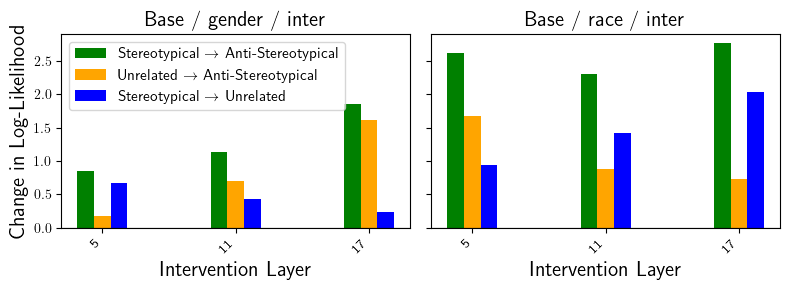

In [ ]:
generate_plots(stereoset_probs, stereo_bias_types, mode)

#### **5.2 Generation of Flow-Charts for Clearer Visualization**
---

**For Changes in Prediction:**

In [ ]:
# these two functions are used to compute the middle figure in figure 1. They calculate where increases/decreases in predictions come from
def get_dict_from_matrix(mat):
    s2a = mat[1][2] - mat[2][1]
    s2u = mat[1][0] - mat[0][1]
    u2a = mat[0][2] - mat[2][0]

    return np.array([s2a, u2a, s2u])

def get_aggregated_flow_per_bias_type(df, bias_type):

    # "U": 0,
    # "S": 1,
    # "A": 2

    # Gonna make a matrix!
    # Previous answers are in the rows
    # New answers are in the columns
    # So: an entry in row 1 column 2 will mean that an answer S (row 1) has been steered to A (col 2)

    df = df[bias_type]
    steered_columns = df.columns[:-4]

    all_changes = []

    original_answers = df.apply(lambda x: determine_answer_type_stereoset(x, pred_column="original"), axis=1)
    for pred_column in steered_columns:
        new_answers = df.apply(lambda x: determine_answer_type_stereoset(x, pred_column=pred_column), axis=1)

        changes = np.zeros((3, 3))
        for entry_idx in range(len(df)):
            row_idx = original_answers[entry_idx]
            col_idx = new_answers[entry_idx]
            changes[row_idx][col_idx] += 1
        answer_flow = get_dict_from_matrix(changes)
        all_changes.append(answer_flow)

    return np.array(all_changes) / len(df)

In [ ]:
changes_in_preds = {}
all_flows = []
for bias_type in stereo_bias_types:
    aggr_flow = get_aggregated_flow_per_bias_type(stereoset_preds[TRAIN_STATE][mode], bias_type)
    all_flows.append(aggr_flow.mean(axis=0))

all_flows = np.array(all_flows)
all_flows.mean(axis=0)

changes_in_preds[mode] = all_flows.mean(axis=0)

**For Changes in Log-Likelihood**

In [ ]:
changes_in_log_likelihood = {}

all_probs = []
for bias_type in stereo_bias_types:
    _, probs, _ = extract_values(stereoset_probs[TRAIN_STATE][mode][bias_type])
    aggr_probs = np.array(probs).mean(axis=1)
    all_probs.append(aggr_probs)

changes_in_log_likelihood[mode] = np.array(all_probs).mean(axis=0)

In [ ]:
from matplotlib.patches import FancyArrowPatch

def draw_plot(data_dict, mode, title, plot="preds"):
    # -- 1) YOUR DATA HERE:
    # Define each edge as (source, target, value, label)

    edge_data = data_dict[mode]
    edge1, edge2, edge3 = edge_data

    if plot == "preds":
        edges = [
            ('Stereotypical', 'Anti-\nStereotypical', edge1, f'{abs(edge1) * 100:.1f}\\%', 0, -0.05),
            ('Unrelated', 'Anti-\nStereotypical', edge2, f'{abs(edge2) * 100:.1f}\\%', +0.15, 0),
            ('Stereotypical', 'Unrelated', edge3, f'{abs(edge3) * 100:.1f}\\%', -0.15, 0)
        ]
    else:
        edges = [
            ('Stereotypical', 'Anti-\nStereotypical', edge1, f'{abs(edge1):.2f}', 0, -0.050),
            ('Unrelated', 'Anti-\nStereotypical', edge2, f'{abs(edge2):.2f}', +0.15, 0),
            ('Stereotypical', 'Unrelated', edge3, f'{abs(edge3):.2f}', -0.15, 0)
        ]

    # -- 2) LINEWIDTH SCALING PARAMETERS:
    min_width, max_width = 0.8, 5
    values = [edge[2] for edge in edges]
    min_val, max_val = min(values), max(values)

    def scale_width(val):
        """Linearly scale val between min_width and max_width."""
        if max_val == min_val:
            return (min_width + max_width) / 2
        return min_width + (val - min_val) / (max_val - min_val) * (max_width - min_width)

    # -- 3) NODE POSITIONS (adjust as you like):
    pos = {
        'Stereotypical': (0, 0.5, "gainsboro"),
        'Anti-\nStereotypical': (1, 0.5, "gainsboro"),
        'Unrelated': (0.5, 0.1, "white")
    }

    # -- 4) PLOTTING:
    fig, ax = plt.subplots(
        figsize=(3.5, 3)
    )

    # Draw nodes
    for node, (x, y, color) in pos.items():
        ax.scatter(x, y, s=2600, zorder=2, color=color, edgecolors="gray", linewidths=0.5)
        ax.text(x, y, node, ha='center', va='center',
                color='black', fontweight='bold', zorder=3)

    # Draw directed edges
    for src, tgt, val, lbl, _x, _y in edges:

        if src == "Unrelated" and tgt == "Anti-\nStereotypical":
            color = "red"
        elif val < 0:
            color = "red"
        else:
            color = "green"

        if val > 0:
            start = pos[src]
            end   = pos[tgt]
        else:
            start = pos[tgt]
            end   = pos[src]
            val *= -1

        lw = scale_width(val)
        arrow = FancyArrowPatch(
            start, end,
            arrowstyle='-|>',         # triangular arrowhead
            mutation_scale=15,        # arrowhead size
            linewidth=lw,
            color=color,
            shrinkA=30, shrinkB=30,
            zorder=1
        )
        ax.add_patch(arrow)

        # Label at midpoint
        mx, my = (start[0]+end[0])/2 + _x, (start[1]+end[1])/2 + _y
        ax.text(mx, my, lbl,
                ha='center', va='center',
                fontstyle='italic', zorder=4)

    # Clean up
    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(0, 0.6)
    ax.axis('off')
    plt.title(f"{title}\n{TRAIN_STATE} - {mode}")
    plt.tight_layout()
    plt.show()

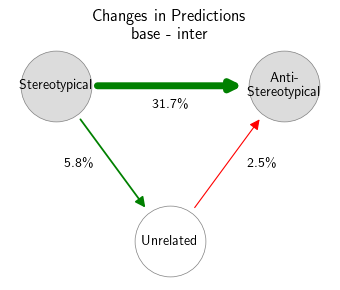

In [ ]:
draw_plot(changes_in_preds, "inter", "Changes in Predictions")

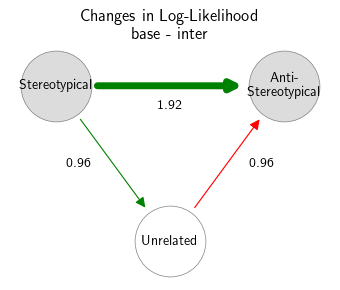

In [ ]:
draw_plot(changes_in_log_likelihood, "inter", "Changes in Log-Likelihood", plot="probs")